# Implementing Transformer Model

#### Installing essential libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Embedding
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

#### Reading the dataset

In [5]:
data=pd.read_csv("C:/Users/riddh/OneDrive/Documents/Projects/Churn/Preprocessed_data.xls")

#### Splitting the data

In [7]:
X = data.drop(columns=['Churn'])  # Features
y = data['Churn']  # Target variable

In [8]:
# Convert data types to float32
X = X.astype('float32')
y = y.astype('float32')

#### Split data into training, validation, and test sets

In [10]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Check the dimension of the sets

In [12]:
# Check the dimension of the sets
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (4930, 36)
y_train: (4930,)
X_test: (1057, 36)
y_test: (1057,)


#### Checking Distribution of Classes

In [14]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 3635, 1.0: 1295}


In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
X_train=X_train_resampled
y_train=y_train_resampled

In [17]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

### Model Designing

In [19]:
# Define Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

#### Define Transformer Model

In [21]:
embed_dim = X_train.shape[1]  # Dimensionality of the feature space
num_heads = 4
ff_dim = 128

inputs = Input(shape=(X_train.shape[1], 1))
x = Dense(embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation='sigmoid')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

#### Compile model

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Training the mdoel

In [25]:
# Early Stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weights) 

Epoch 1/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5112 - loss: 0.7484 - val_accuracy: 0.0536 - val_loss: 0.9000
Epoch 2/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5891 - loss: 0.6833 - val_accuracy: 0.3391 - val_loss: 0.8302
Epoch 3/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6054 - loss: 0.6740 - val_accuracy: 0.0908 - val_loss: 0.9811
Epoch 4/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6205 - loss: 0.6594 - val_accuracy: 0.1644 - val_loss: 0.9083
Epoch 5/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6009 - loss: 0.6666 - val_accuracy: 0.0626 - val_loss: 1.0691
Epoch 6/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6110 - loss: 0.6552 - val_accuracy: 0.1417 - val_loss: 0.9376
Epoch 7/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6284 - loss: 0.6422 - val_accuracy: 0.2001 - val_loss: 0.8721
Epoch 8/300
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6139 - loss: 0.6565 - val_accu

#### Evaluating the model

In [27]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test,verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7703 - loss: 0.4810
Test Loss: 0.5054829120635986
Test Accuracy: 0.7530747652053833


In [28]:
yhat_test_prob = model.predict(X_test)
yhat_test = (yhat_test_prob > 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, yhat_test)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, yhat_test))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[664  97]
 [164 132]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84       761
         1.0       0.58      0.45      0.50       296

    accuracy                           0.75      1057
   macro avg       0.69      0.66      0.67      1057
weighted avg       0.74      0.75      0.74      1057



<Axes: >

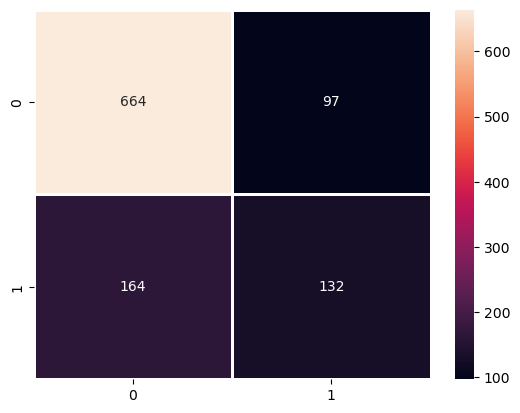

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm2=confusion_matrix(y_test, yhat_test)
sns.heatmap(cm2, linewidths=1, annot=True, fmt='g')

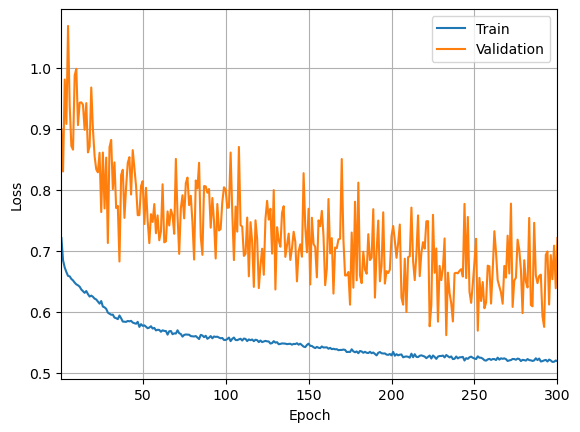

In [30]:
# Plot loss vs epochs
import matplotlib.pyplot as plt
import seaborn as sns
epoch_range = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.xlim((1, len(history.history['loss'])))
plt.legend(['Train', 'Validation'])
plt.show()

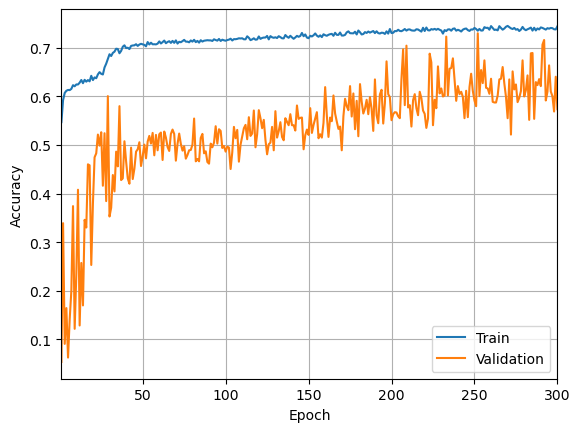

In [31]:
# Plot accuracy vs epochs
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.xlim((1, len(history.history['accuracy'])))
plt.legend(['Train', 'Validation'])
plt.show()

In [32]:
y_pred = model.predict(X_test)
print(y_test[:5])
print(y_pred[:5])

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23      0.0
3114    0.0
5525    0.0
437     0.0
3615    1.0
Name: Churn, dtype: float32
[[0.2385808 ]
 [0.53719735]
 [0.11647335]
 [0.09193885]
 [0.4370974 ]]


In [33]:
y_pred =[1 if y_pred[aa]>=0.5 else 0 for aa in range(len(y_pred)) ]
print(y_pred[:5])

[0, 1, 0, 0, 0]


In [34]:
import sklearn 
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84       761
         1.0       0.58      0.45      0.50       296

    accuracy                           0.75      1057
   macro avg       0.69      0.66      0.67      1057
weighted avg       0.74      0.75      0.74      1057

